# Spatial Analysis
## NutriNet: Maya Coronado, Savannah Gourley, Xander Lee, Kiran Rao
In our group project, we aim to isolate contributing factors to low birth weight throughout the city of Los Angeles, focusing on SPA  4 & 5. As our data is aggregated at the census tract level, we decided to isolate our main contributing factor and look at food insecurity. We want to contextualize and focus on the availability of retailers that accept SPA, set against the Low Birth Weight rates of specific census tracts. The aim is to see if there are clusters of SNAP accepters and what that relates to. We have an initial hypothesis that the more low-income or CalFresh cases there are there will be more SNAP retailers; the amount of CalFresh cases in a certain census tract is also being used as a contributing variable to understand the food insecurity rate of certain regions. 

Below, we will do some data "wrangling" and clean up, merging together our relevant data sets with other relevant groups.

In [2]:
# to read and wrangle data
import pandas as pd
import numpy as np

# to import data from LA Data portal
from sodapy import Socrata

# to create spatial data
import geopandas as gpd

# for basemaps
import contextily as ctx

# For spatial statistics
import esda
from esda.moran import Moran, Moran_Local

import splot
from splot.esda import moran_scatterplot, plot_moran, lisa_cluster,plot_moran_simulation

import libpysal as lps

# Graphics
import matplotlib.pyplot as plt
import plotly.express as px

import folium

In [3]:
df = pd.read_csv('data/Main Data - main (1).csv')
censusdata = gpd.read_file('data/Census_Tracts_2020.geojson')

In [4]:
censusdata['tract']='06' + '037' + censusdata ['CT20']

In [5]:
df.columns = ['Unnamed: 0', 'ignore', 'tract', 'sup_dist', 'csa', 'spa',
       'ESRI_OID', 'Shape__Area', 'Shape__Length', 'Total Woman 15-50',
       'Women with births 12 Months', 'Total Population', 'Birth Rate',
       'Fertility Rate', 'Low Birth Weight', 'Low Birth Weight Pctl',
       'Average income', 'Grocery Store Access',
       'Grocery Store Access Percent','CalFresh Cases','CF cases per 100']
df.columns

Index(['Unnamed: 0', 'ignore', 'tract', 'sup_dist', 'csa', 'spa', 'ESRI_OID',
       'Shape__Area', 'Shape__Length', 'Total Woman 15-50',
       'Women with births 12 Months', 'Total Population', 'Birth Rate',
       'Fertility Rate', 'Low Birth Weight', 'Low Birth Weight Pctl',
       'Average income', 'Grocery Store Access',
       'Grocery Store Access Percent', 'CalFresh Cases', 'CF cases per 100'],
      dtype='object')

In [6]:
df['census tract']='0'+ df['tract'].apply(str)

Note: Because our data is at the tract level, we also kept the boundaries/blocks of our census tracts appropiately. 

In [7]:
df.head()

,Unnamed: 0,ignore,tract,sup_dist,csa,spa,ESRI_OID,Shape__Area,Shape__Length,Total Woman 15-50,...,Birth Rate,Fertility Rate,Low Birth Weight,Low Birth Weight Pctl,Average income,Grocery Store Access,Grocery Store Access Percent,CalFresh Cases,CF cases per 100,census tract
0,0,6037199700,6037199700,District 1,Los Angeles - Wholesale District,SPA 4 - Metro,2347,1.041050e+07,13808.463240,678,...,0.006779,0.033923,6.52,83.85,38892.0,0.0,0.0,301.0,43.8,06037199700
1,0,6037199801,6037199801,District 1,Los Angeles - Lincoln Heights,SPA 4 - Metro,2348,3.724107e+06,9459.391827,911,...,0.027997,0.093304,0.00,0.00,41027.0,0.0,0.0,286.0,36.2,06037199801
2,0,6037199802,6037199802,District 1,Los Angeles - Lincoln Heights,SPA 4 - Metro,2349,3.296129e+06,8868.744225,458,...,0.006996,0.032751,0.00,0.00,42500.0,0.0,0.0,242.0,49.1,06037199802
3,0,6037199900,6037199900,District 1,Los Angeles - Lincoln Heights,SPA 4 - Metro,2350,4.782361e+06,10141.728020,573,...,0.003786,0.017452,5.43,62.88,37232.0,0.0,0.0,264.0,50.7,06037199900
4,0,6037201110,6037201110,District 1,Los Angeles - El Sereno,SPA 4 - Metro,2351,1.099246e+07,15893.383640,715,...,0.015866,0.051748,7.08,90.67,65000.0,0.0,0.0,136.0,26.0,06037201110


In [8]:
censusdata.head()

,OBJECTID,CT20,LABEL,ShapeSTArea,ShapeSTLength,geometry,tract
0,1,101110,1011.10,1.229562e+07,15083.854287,"POLYGON ((-118.28491 34.25948, -118.28492 34.2...",06037101110
1,2,101122,1011.22,2.845774e+07,31671.455844,"POLYGON ((-118.29015 34.27417, -118.29015 34.2...",06037101122
2,3,101220,1012.20,7.522093e+06,12698.783810,"POLYGON ((-118.28100 34.25592, -118.28198 34.2...",06037101220
3,4,101221,1012.21,3.812000e+06,9161.710543,"POLYGON ((-118.28735 34.25591, -118.28863 34.2...",06037101221
4,5,101222,1012.22,3.191371e+06,9980.600461,"POLYGON ((-118.28594 34.25405, -118.28594 34.2...",06037101222


In [9]:
censusdata['census tract']='06' + '037' + censusdata ['CT20']

In [10]:
LBW=censusdata.merge(df,on="census tract")

In [11]:
SPA=gpd.read_file('data/Service_Planning_Areas_2022_(view).geojson')

In [12]:
selected_SPAs = SPA[SPA['LABEL'].isin(['SPA 4','SPA 5'])]

In [13]:
our_SPA=gpd.GeoDataFrame(selected_SPAs)

In [14]:
SNAP= pd.read_csv('data/SNAP_Retailer_Location_data.csv')

In [15]:
SNAP.shape

(8132, 17)

In [16]:
SNAP.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8132 entries, 0 to 8131
Data columns (total 17 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   X                     8132 non-null   float64
 1   Y                     8132 non-null   float64
 2   Record_ID             8132 non-null   int64  
 3   Store_Name            8132 non-null   object 
 4   Store_Street_Address  8132 non-null   object 
 5   Additonal_Address     746 non-null    object 
 6   City                  8132 non-null   object 
 7   State                 8132 non-null   object 
 8   Zip_Code              8132 non-null   int64  
 9   Zip4                  8132 non-null   object 
 10  County                8132 non-null   object 
 11  Store_Type            8132 non-null   object 
 12  Latitude              8132 non-null   float64
 13  Longitude             8132 non-null   float64
 14  Incentive_Program     89 non-null     object 
 15  Grantee_Name         

In [17]:
SNAP = gpd.GeoDataFrame(SNAP, 
                         crs='EPSG:4326',
                         geometry=gpd.points_from_xy(SNAP.X, SNAP.Y))

In [18]:
SNAP_clip = gpd.clip(SNAP, our_SPA)

In [19]:
SNAP_clip = SNAP_clip.to_crs(epsg=3857)

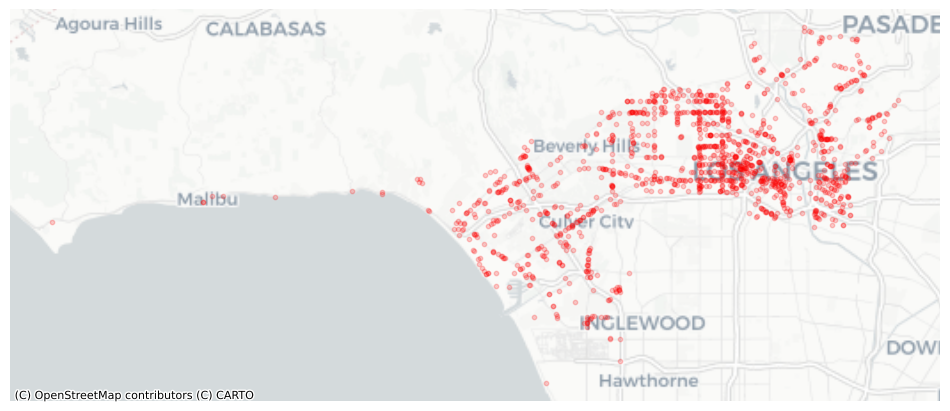

In [20]:
fig,ax = plt.subplots(figsize=(12,12))

SNAP_clip.plot(ax=ax,
             color='red',
             markersize=10,
              alpha=0.2)

# no axis
ax.axis('off')

# add a basemap
ctx.add_basemap(ax,source=ctx.providers.CartoDB.Positron)

Above, we've successfully mapped all SNAP retailers in SPA 4 & 5. We can immediately see a clustering towards downtown and spacing out towards the Westside.

In [21]:
minx, miny, maxx, maxy = SNAP_clip.geometry.total_bounds
print(minx)
print(maxx)
print(miny)
print(maxy)

-13225808.588623803
-13153034.58471261
4017685.127765333
4048354.4142391556


In [22]:
LBW.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 537 entries, 0 to 536
Data columns (total 29 columns):
 #   Column                        Non-Null Count  Dtype   
---  ------                        --------------  -----   
 0   OBJECTID                      537 non-null    int64   
 1   CT20                          537 non-null    object  
 2   LABEL                         537 non-null    object  
 3   ShapeSTArea                   537 non-null    float64 
 4   ShapeSTLength                 537 non-null    float64 
 5   geometry                      537 non-null    geometry
 6   tract_x                       537 non-null    object  
 7   census tract                  537 non-null    object  
 8   Unnamed: 0                    537 non-null    int64   
 9   ignore                        537 non-null    int64   
 10  tract_y                       537 non-null    int64   
 11  sup_dist                      537 non-null    object  
 12  csa                           537 non-null

In [23]:
LBW = LBW.to_crs(epsg=3857)

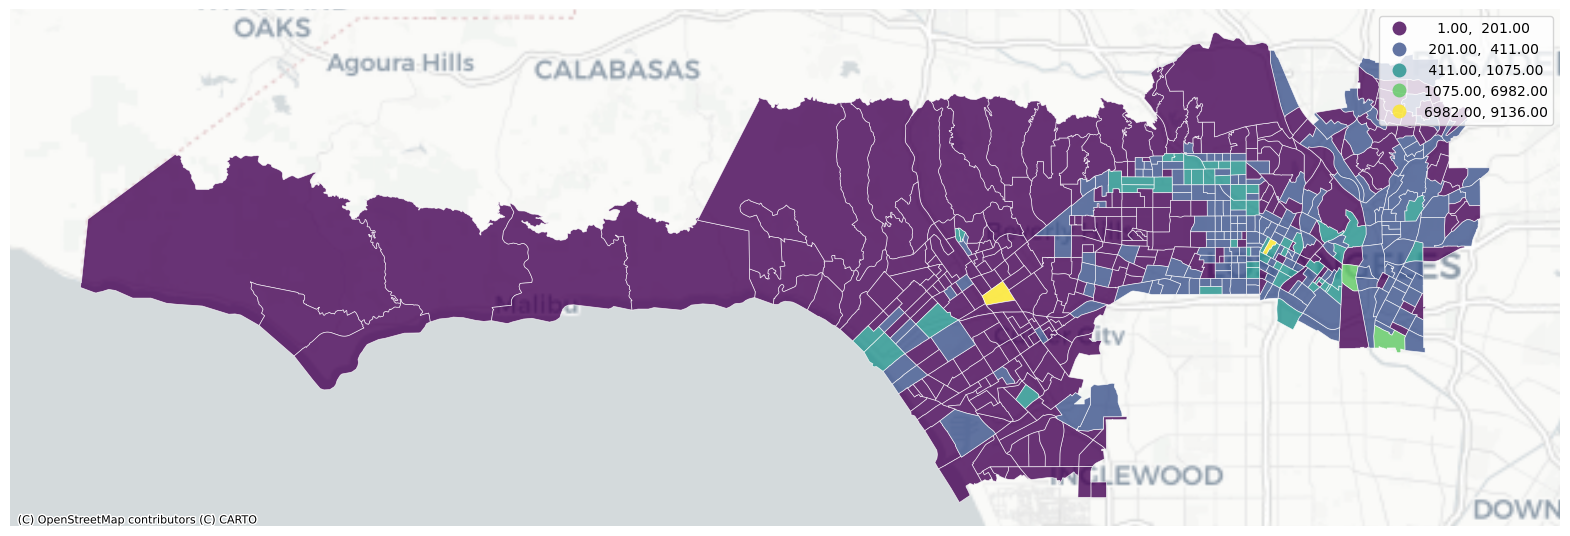

In [24]:

# plot it!
fig, ax = plt.subplots(figsize=(20,20))

LBW.plot(ax=ax,
         column='CalFresh Cases',
         scheme='naturalbreaks', 
         edgecolor='white',
         legend=True,
         lw=0.5,
         alpha=0.8)

# no axis
ax.axis('off')

# add a basemap
ctx.add_basemap(ax,source=ctx.providers.CartoDB.Positron)

To compare our metrics, we've also added another "basemap" that correlates the amount of CalFresh household cases per census tract using a simple plot. We also see higher amounts in the Downtown area. Below, we've overlayed the SNAP "acceptors" on the tract-level map showing the CalFresh cases. The map follows the pattern we hypothesized, with clusters of retailers around tracts with higher levels of cases. 

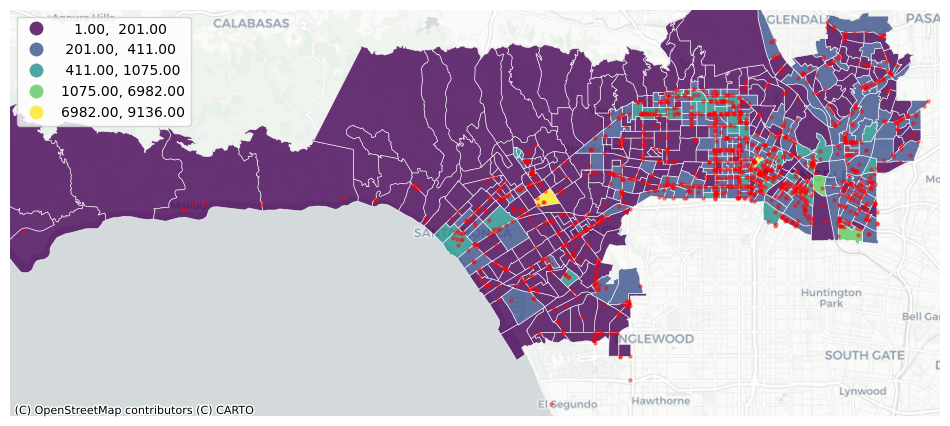

In [26]:
# plot it!
fig, ax = plt.subplots(figsize=(12,12))

LBW.plot(ax=ax,
         column='CalFresh Cases', 
         scheme='naturalbreaks',
         edgecolor='white',
         legend=True,
         lw=0.5,
         alpha=0.8)

SNAP_clip.plot(ax=ax, # this also puts it in the same ax plot
        color='red',
        markersize=5,
        alpha=0.4)

ax.set_xlim(minx - 1000, maxx + 1000) # added/substracted value is to give some margin around total bounds
ax.set_ylim(miny - 1000, maxy + 1000)

# no axis
ax.axis('off')

# add a basemap
ctx.add_basemap(ax,source=ctx.providers.CartoDB.Positron)

Below, we overlay our grocery stores on top of a rate derived from our data set -- of CF cases per 100. 

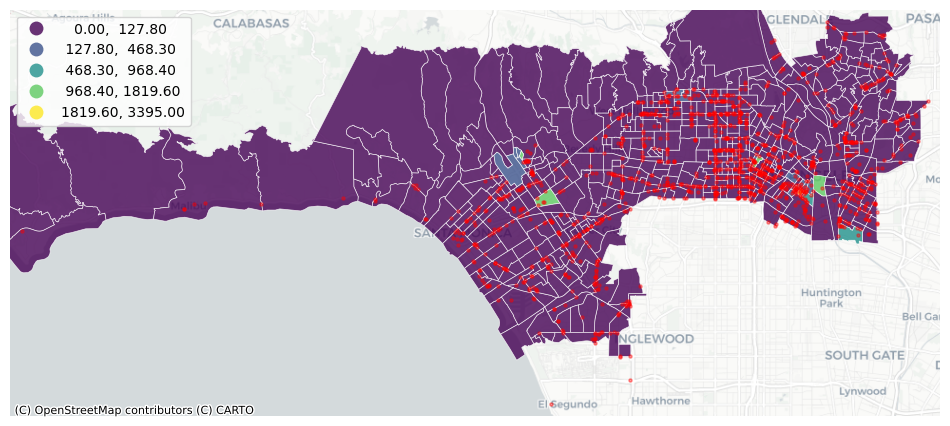

In [27]:
# plot it!
fig, ax = plt.subplots(figsize=(12,12))

LBW.plot(ax=ax,
         column='CF cases per 100', 
         scheme='naturalbreaks',
         edgecolor='white',
         legend=True,
         lw=0.5,
         alpha=0.8)

SNAP_clip.plot(ax=ax, # this also puts it in the same ax plot
        color='red',
        markersize=5,
        alpha=0.4)

ax.set_xlim(minx - 1000, maxx + 1000) # added/substracted value is to give some margin around total bounds
ax.set_ylim(miny - 1000, maxy + 1000)

# no axis
ax.axis('off')

# add a basemap
ctx.add_basemap(ax,source=ctx.providers.CartoDB.Positron)

For our project's purposes, we've gone ahead and created the base map looking at the % of Low Birth Weights on a census tract level and see significant clustering again by the downtown area. 

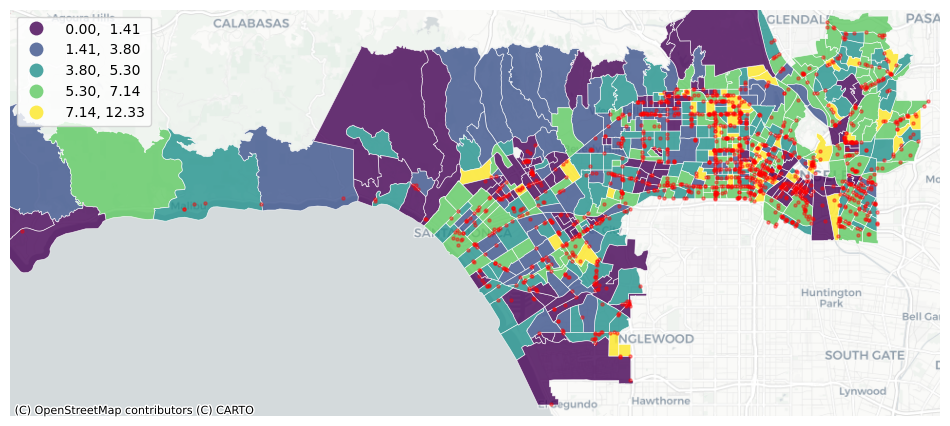

In [28]:
# plot it!
fig, ax = plt.subplots(figsize=(12,12))

LBW.plot(ax=ax,
         column='Low Birth Weight', 
         scheme='naturalbreaks',
         edgecolor='white',
         legend=True,
         lw=0.5,
         alpha=0.8)

SNAP_clip.plot(ax=ax, # this also puts it in the same ax plot
        color='red',
        markersize=5,
        alpha=0.4)

ax.set_xlim(minx - 1000, maxx + 1000) # added/substracted value is to give some margin around total bounds
ax.set_ylim(miny - 1000, maxy + 1000)

# no axis
ax.axis('off')

# add a basemap
ctx.add_basemap(ax,source=ctx.providers.CartoDB.Positron)

From here, we will conduct a join function to allow us to isolate the amount of SNAP retailers per census tract and pull out significant tracts. 

In [30]:
join = gpd.sjoin(LBW, SNAP_clip, how='left')

In [31]:
join.shape

(1503, 47)

In [32]:
join.columns

Index(['OBJECTID', 'CT20', 'LABEL', 'ShapeSTArea', 'ShapeSTLength', 'geometry',
       'tract_x', 'census tract', 'Unnamed: 0', 'ignore', 'tract_y',
       'sup_dist', 'csa', 'spa', 'ESRI_OID', 'Shape__Area', 'Shape__Length',
       'Total Woman 15-50', 'Women with births 12 Months', 'Total Population',
       'Birth Rate', 'Fertility Rate', 'Low Birth Weight',
       'Low Birth Weight Pctl', 'Average income', 'Grocery Store Access',
       'Grocery Store Access Percent', 'CalFresh Cases', 'CF cases per 100',
       'index_right', 'X', 'Y', 'Record_ID', 'Store_Name',
       'Store_Street_Address', 'Additonal_Address', 'City', 'State',
       'Zip_Code', 'Zip4', 'County', 'Store_Type', 'Latitude', 'Longitude',
       'Incentive_Program', 'Grantee_Name', 'ObjectId'],
      dtype='object')

In [33]:
join.columns =['OBJECTID', 'CT20', 'LABEL', 'ShapeSTArea', 'ShapeSTLength', 'geometry',
       'tract_x', 'census_tract', 'Unnamed: 0', 'ignore', 'tract_y',
       'sup_dist', 'csa', 'spa', 'ESRI_OID', 'Shape__Area', 'Shape__Length',
       'Total Woman 15-50', 'Women with births 12 Months', 'Total Population',
       'Birth Rate', 'Fertility Rate', 'Low Birth Weight',
       'Low Birth Weight Pctl', 'Average income', 'Grocery Store Access',
       'Grocery Store Access Percent', 'CalFresh Cases', 'CF cases per 100',
       'index_right', 'X', 'Y', 'Record_ID', 'Store_Name',
       'Store_Street_Address', 'Additonal_Address', 'City', 'State',
       'Zip_Code', 'Zip4', 'County', 'Store_Type', 'Latitude', 'Longitude',
       'Incentive_Program', 'Grantee_Name', 'ObjectId']

In [34]:
SNAP_by_tract = join.census_tract.value_counts().rename_axis('census_tract').reset_index(name='SNAP_count')


<Axes: xlabel='census_tract'>

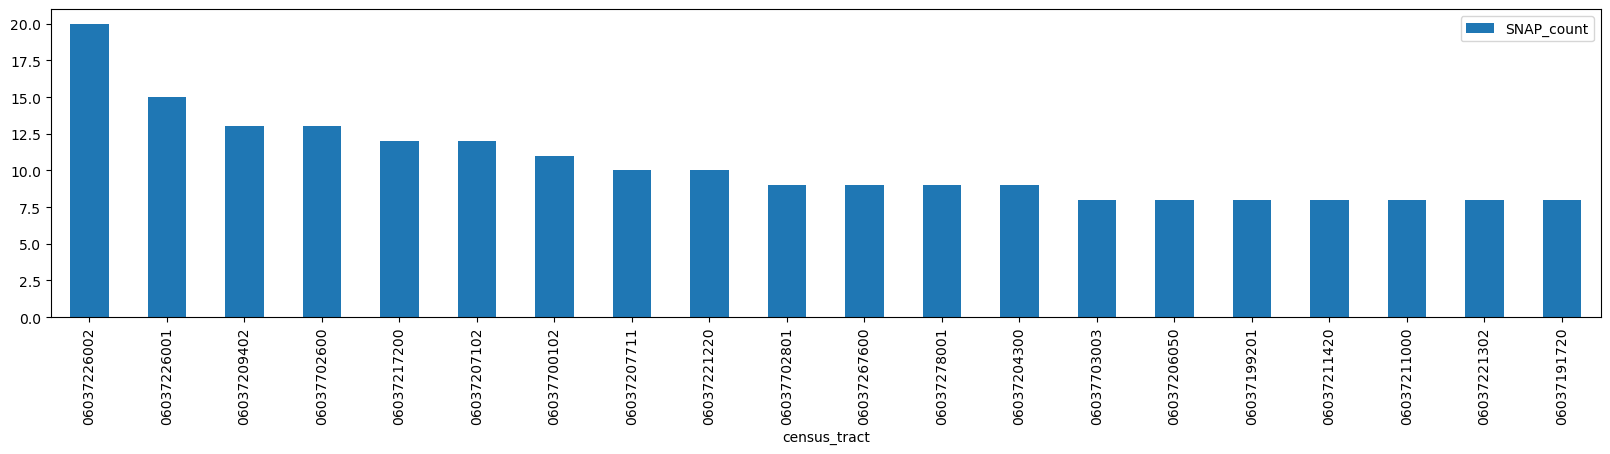

In [35]:
SNAP_by_tract[:20].plot.bar(figsize=(20,4),
                             x='census_tract',
                             y='SNAP_count')

We have the top 20 census tracts above, sorted by the amount of SNAP retailers they have. 

<Axes: ylabel='Frequency'>

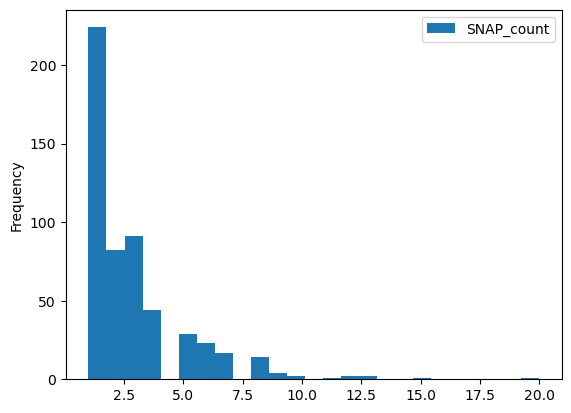

In [36]:
SNAP_by_tract.plot.hist(bins=25)

{'whiskers': [<matplotlib.lines.Line2D at 0x7c58c4492590>,
 'caps': [<matplotlib.lines.Line2D at 0x7c58c4493850>,
 'boxes': [<matplotlib.lines.Line2D at 0x7c58c44839d0>],
 'medians': [<matplotlib.lines.Line2D at 0x7c58c449c790>],
 'fliers': [<matplotlib.lines.Line2D at 0x7c58c449d050>],
 'means': []}

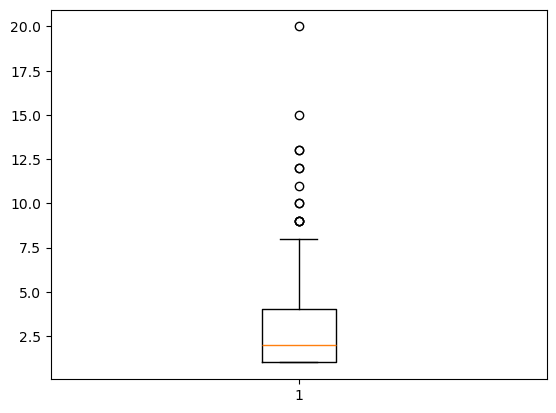

In [37]:
plt.boxplot(SNAP_by_tract.SNAP_count)

In [38]:
LBW.columns

Index(['OBJECTID', 'CT20', 'LABEL', 'ShapeSTArea', 'ShapeSTLength', 'geometry',
       'tract_x', 'census tract', 'Unnamed: 0', 'ignore', 'tract_y',
       'sup_dist', 'csa', 'spa', 'ESRI_OID', 'Shape__Area', 'Shape__Length',
       'Total Woman 15-50', 'Women with births 12 Months', 'Total Population',
       'Birth Rate', 'Fertility Rate', 'Low Birth Weight',
       'Low Birth Weight Pctl', 'Average income', 'Grocery Store Access',
       'Grocery Store Access Percent', 'CalFresh Cases', 'CF cases per 100'],
      dtype='object')

In [39]:
LBW.columns = ['OBJECTID', 'CT20', 'LABEL', 'ShapeSTArea', 'ShapeSTLength', 'geometry',
       'tract_x', 'census_tract', 'Unnamed: 0', 'ignore', 'tract_y',
       'sup_dist', 'csa', 'spa', 'ESRI_OID', 'Shape__Area', 'Shape__Length',
       'Total Woman 15-50', 'Women with births 12 Months', 'Total_Pop',
       'Birth Rate', 'Fertility Rate', 'Low Birth Weight',
       'Low Birth Weight Pctl', 'Average income', 'Grocery Store Access',
       'Grocery Store Access Percent', 'CalFresh Cases', 'CF cases per 100']

In [40]:
LBW = LBW.merge(SNAP_by_tract,on='census_tract')

In [41]:
LBW.sample(10)

,OBJECTID,CT20,LABEL,ShapeSTArea,ShapeSTLength,geometry,tract_x,census_tract,Unnamed: 0,ignore,...,Birth Rate,Fertility Rate,Low Birth Weight,Low Birth Weight Pctl,Average income,Grocery Store Access,Grocery Store Access Percent,CalFresh Cases,CF cases per 100,SNAP_count
309,701,215102,2151.02,2.774274e+06,8182.358919,"POLYGON ((-13174175.403 4038056.408, -13174239...",06037215102,06037215102,0,6037215102,...,0.003522,0.008682,4.07,28.36,76221.0,0.0,0.000000,166.0,53.5,2
361,928,264000,2640.00,2.010706e+07,22982.742080,"POLYGON ((-13188179.732 4036554.623, -13188174...",06037264000,06037264000,0,6037264000,...,0.012180,0.076775,10.20,99.64,196250.0,8.0,0.002382,20.0,2.2,1
340,765,224200,2242.00,3.963203e+06,8643.300182,"POLYGON ((-13166189.230 4033937.592, -13166187...",06037224200,06037224200,0,6037224200,...,0.000000,0.000000,7.62,94.71,36071.0,0.0,0.000000,242.0,44.6,4
386,953,265702,2657.02,4.040548e+06,8775.757934,"POLYGON ((-13182819.029 4037164.801, -13182814...",06037265702,06037265702,0,6037265702,...,0.014936,0.091295,0.00,0.00,91731.0,0.0,0.000000,107.0,15.0,1
159,551,201503,2015.03,4.729129e+06,9203.947941,"POLYGON ((-13154805.586 4040536.749, -13154806...",06037201503,06037201503,0,6037201503,...,0.008173,0.025432,5.72,69.35,50344.0,0.0,0.000000,252.0,33.5,4
460,1027,275500,2755.00,8.479394e+06,11765.886742,"POLYGON ((-13181124.412 4027733.356, -13181120...",06037275500,06037275500,0,6037275500,...,0.003580,0.016281,3.24,11.95,43393.0,0.0,0.000000,431.0,40.2,5
426,993,271500,2715.00,9.795954e+06,13061.357078,"POLYGON ((-13184423.032 4030304.110, -13184290...",06037271500,06037271500,0,6037271500,...,0.003231,0.017889,3.03,9.64,98452.0,0.0,0.000000,55.0,6.4,1
347,914,261104,2611.04,4.949216e+07,45653.617291,"POLYGON ((-13180993.501 4046116.698, -13180998...",06037261104,06037261104,0,6037261104,...,0.010989,0.077922,0.00,0.00,217396.0,2404.0,0.999584,14.0,3.5,1
431,998,271801,2718.01,5.165917e+06,9610.551951,"POLYGON ((-13181879.826 4031111.510, -13182041...",06037271801,06037271801,0,6037271801,...,0.008183,0.027599,4.98,51.82,54259.0,0.0,0.000000,175.0,28.5,3
512,2269,702202,7022.02,1.088986e+07,13839.062703,"POLYGON ((-13187363.314 4029577.875, -13187342...",06037702202,06037702202,0,6037702202,...,0.000000,0.000000,3.61,18.40,120268.0,0.0,0.000000,85.0,9.1,2


In [42]:
LBW['SNAP_per_1000'] = LBW['SNAP_count']/LBW['Total_Pop']*1000

Here we add a new column which is the rate of SNAP retailers normalized per 1000 residents.

In [43]:
LBW.sort_values(by="SNAP_per_1000").tail()

,OBJECTID,CT20,LABEL,ShapeSTArea,ShapeSTLength,geometry,tract_x,census_tract,Unnamed: 0,ignore,...,Fertility Rate,Low Birth Weight,Low Birth Weight Pctl,Average income,Grocery Store Access,Grocery Store Access Percent,CalFresh Cases,CF cases per 100,SNAP_count,SNAP_per_1000
534,2478,980019,9800.19,4.761975e+08,155767.638460,"POLYGON ((-13195202.101 4046322.319, -13195200...",06037980019,06037980019,0,6037980019,...,0.0,0.0,0.00,250001.0,73.0,0.296748,1.0,6.3,1,7.812500
531,2468,980009,9800.09,2.288694e+08,81127.024463,"POLYGON ((-13169579.690 4050151.005, -13169628...",06037980009,06037980009,0,6037980009,...,0.0,0.0,0.00,NaN,0.0,0.000000,1.0,0.0,1,19.230769
536,2494,980038,9800.38,4.861673e+07,42991.767229,"POLYGON ((-13176525.692 4030868.156, -13176524...",06037980038,06037980038,0,6037980038,...,NaN,0.0,0.00,NaN,NaN,NaN,NaN,NaN,1,250.000000
535,2486,980028,9800.28,2.119243e+08,85718.579965,"POLYGON ((-13178640.094 4022802.672, -13178707...",06037980028,06037980028,0,6037980028,...,NaN,0.0,0.00,NaN,NaN,NaN,NaN,NaN,3,272.727273
477,1044,277400,2774.00,6.877749e+06,10438.697565,"POLYGON ((-13177816.218 4022445.693, -13177823...",06037277400,06037277400,0,6037277400,...,NaN,10.0,99.51,34318.0,647.0,0.422048,3.0,2.5,2,666.666667


In [44]:
LBW.sort_values(by="Total_Pop").tail()

,OBJECTID,CT20,LABEL,ShapeSTArea,ShapeSTLength,geometry,tract_x,census_tract,Unnamed: 0,ignore,...,Fertility Rate,Low Birth Weight,Low Birth Weight Pctl,Average income,Grocery Store Access,Grocery Store Access Percent,CalFresh Cases,CF cases per 100,SNAP_count,SNAP_per_1000
523,2280,703002,7030.02,3.527085e+07,27859.362899,"POLYGON ((-13176391.663 4028501.769, -13176378...",06037703002,06037703002,0,6037703002,...,0.007869,4.87,48.77,101264.0,617.0,0.092964,226.0,13.1,3,0.434342
215,607,207902,2079.02,7.532287e+06,11167.818144,"POLYGON ((-13164236.463 4033589.936, -13164101...",06037207902,06037207902,0,6037207902,...,0.033510,0.00,0.00,106206.0,0.0,0.000000,279.0,36.3,4,0.540176
462,1029,275604,2756.04,1.668909e+07,25536.539830,"POLYGON ((-13180180.645 4026600.903, -13180218...",06037275604,06037275604,0,6037275604,...,0.068323,0.00,0.00,173569.0,0.0,0.000000,102.0,4.3,3,0.285171
522,2279,702900,7029.00,4.043091e+07,25965.913567,"POLYGON ((-13183970.629 4025345.738, -13183965...",06037702900,06037702900,0,6037702900,...,0.053634,0.00,0.00,120437.0,137.0,0.015484,309.0,16.1,3,0.263783
372,939,265301,2653.01,1.717677e+07,20495.487120,"POLYGON ((-13184428.710 4038711.686, -13184448...",06037265301,06037265301,0,6037265301,...,0.000000,0.00,0.00,NaN,0.0,0.000000,144.0,0.0,3,0.221779


In [45]:
LBW = LBW.astype({"Total_Pop":int})

In [46]:
LBW3= LBW.query('Total_Pop > 20')

Above we make a new dataframe which drops census tracts with populations below 20 so as to avoid outliers with no residents such as LAX, after having changed the datatype to integer to work with the query. 

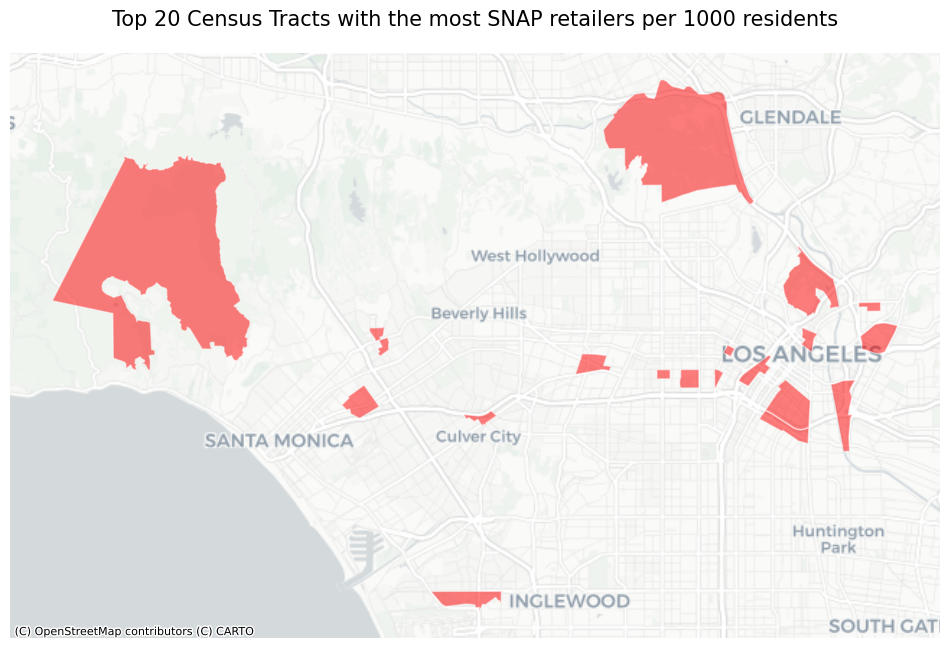

In [47]:
# map the top 20 geographies
fig,ax = plt.subplots(figsize=(12,10))
LBW3.sort_values(by='SNAP_per_1000',ascending=False)[:20].plot(ax=ax,
                                                                 color='red',
                                                                 edgecolor='white',
                                                                 alpha=0.5)

# title
ax.set_title('Top 20 Census Tracts with the most SNAP retailers per 1000 residents',fontsize=15,pad=20)

# no axis
ax.axis('off')

# add a basemap
ctx.add_basemap(ax,source=ctx.providers.CartoDB.Positron)

Here is a map showing CTs with the highest normalized rate of SNAP retailers per 1000 residents. Interestingly, we see high rates of SNAP retailers near Skid Row, above LAX, in the Santa Monica Mountains, and in Glendale.

In [48]:
wq =  lps.weights.KNN.from_dataframe(LBW3,k=4)

In [49]:
wq.transform = 'r'

We have set our weights for the neighbor and row normalized the data. Next, we will add a column for the spatial lag in our LBW3 data frame

In [50]:
LBW3['SNAP_per_1000_lag'] = lps.weights.lag_spatial(wq, LBW3['SNAP_per_1000'])

/opt/conda/lib/python3.11/site-packages/geopandas/geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [51]:
LBW3.sample(10)[['census_tract','Total_Pop','SNAP_count','SNAP_per_1000','SNAP_per_1000_lag']]

,census_tract,Total_Pop,SNAP_count,SNAP_per_1000,SNAP_per_1000_lag
175,06037204120,2368,3,1.266892,1.364559
76,06037190702,1420,2,1.408451,1.165032
224,06037208610,3878,2,0.515730,1.201816
533,06037980017,1192,1,0.838926,0.361380
276,06037212305,2533,1,0.394789,0.569553
165,06037203200,4264,6,1.407129,1.032686
367,06037264306,2228,2,0.897666,0.685156
344,06037226002,3587,20,5.575690,2.679725
368,06037265100,2835,1,0.352734,0.407921
474,06037277000,5637,1,0.177399,1.082025


In [52]:
LBW3['SNAP_count_lag_diff'] = LBW3['SNAP_per_1000'] - LBW3['SNAP_per_1000_lag']

/opt/conda/lib/python3.11/site-packages/geopandas/geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


Here we add a new column of spatial lag differences defined using the math query. 

In [53]:
LBW3.sort_values(by='SNAP_count_lag_diff')

,OBJECTID,CT20,LABEL,ShapeSTArea,ShapeSTLength,geometry,tract_x,census_tract,Unnamed: 0,ignore,...,Low Birth Weight Pctl,Average income,Grocery Store Access,Grocery Store Access Percent,CalFresh Cases,CF cases per 100,SNAP_count,SNAP_per_1000,SNAP_per_1000_lag,SNAP_count_lag_diff
191,583,206051,2060.51,4.015774e+07,30027.529715,"POLYGON ((-13161437.780 4034377.954, -13161455...",06037206051,06037206051,0,6037206051,...,0.00,119453.0,6.0,0.002574,83.0,34.2,3,1.157854,4.033641,-2.875787
379,946,265521,2655.21,1.409937e+06,5592.735680,"POLYGON ((-13185068.129 4036095.232, -13185153...",06037265521,06037265521,0,6037265521,...,0.00,51014.0,0.0,0.000000,158.0,54.9,1,0.513347,2.788477,-2.275130
370,937,265203,2652.03,3.337200e+06,8484.000961,"POLYGON ((-13184124.696 4037472.656, -13184126...",06037265203,06037265203,0,6037265203,...,0.00,56656.0,0.0,0.000000,92.0,22.0,1,0.448833,2.631422,-2.182589
132,524,197200,1972.00,8.364430e+06,14833.141771,"POLYGON ((-13162333.457 4041587.511, -13162438...",06037197200,06037197200,0,6037197200,...,12.97,62612.0,0.0,0.000000,245.0,30.2,1,0.304229,2.377190,-2.072961
133,525,197300,1973.00,7.042091e+06,15215.654315,"POLYGON ((-13163599.048 4039765.776, -13163598...",06037197300,06037197300,0,6037197300,...,79.73,86326.0,0.0,0.000000,241.0,32.2,2,0.547945,2.540565,-1.992620
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
212,604,207711,2077.11,7.469515e+06,14744.237737,"POLYGON ((-13164565.635 4035017.571, -13164535...",06037207711,06037207711,0,6037207711,...,0.00,121477.0,0.0,0.000000,95.0,37.4,10,4.385965,0.631321,3.754644
371,938,265204,2652.04,2.855371e+06,7517.683586,"POLYGON ((-13185123.121 4036694.635, -13185108...",06037265204,06037265204,0,6037265204,...,0.00,108295.0,0.0,0.000000,86.0,47.5,7,5.922166,0.439049,5.483116
532,2469,980010,9800.10,4.126462e+07,36580.178340,"POLYGON ((-13160979.700 4039666.452, -13160996...",06037980010,06037980010,0,6037980010,...,NaN,31875.0,0.0,0.000000,21.0,77.8,1,6.944444,0.417733,6.526711
534,2478,980019,9800.19,4.761975e+08,155767.638460,"POLYGON ((-13195202.101 4046322.319, -13195200...",06037980019,06037980019,0,6037980019,...,0.00,250001.0,73.0,0.296748,1.0,6.3,1,7.812500,0.250901,7.561599


In [54]:
LBW3_donut = LBW3.sort_values(by='SNAP_count_lag_diff').head(1)
LBW3_donut

,OBJECTID,CT20,LABEL,ShapeSTArea,ShapeSTLength,geometry,tract_x,census_tract,Unnamed: 0,ignore,...,Low Birth Weight Pctl,Average income,Grocery Store Access,Grocery Store Access Percent,CalFresh Cases,CF cases per 100,SNAP_count,SNAP_per_1000,SNAP_per_1000_lag,SNAP_count_lag_diff
191,583,206051,2060.51,4.015774e+07,30027.529715,"POLYGON ((-13161437.780 4034377.954, -13161455...",06037206051,06037206051,0,6037206051,...,0.0,119453.0,6.0,0.002574,83.0,34.2,3,1.157854,4.033641,-2.875787


In [55]:
LBW3_diamond= LBW3.sort_values(by='SNAP_count_lag_diff').tail(1)
LBW3_diamond

,OBJECTID,CT20,LABEL,ShapeSTArea,ShapeSTLength,geometry,tract_x,census_tract,Unnamed: 0,ignore,...,Low Birth Weight Pctl,Average income,Grocery Store Access,Grocery Store Access Percent,CalFresh Cases,CF cases per 100,SNAP_count,SNAP_per_1000,SNAP_per_1000_lag,SNAP_count_lag_diff
531,2468,980009,9800.09,2.288694e+08,81127.024463,"POLYGON ((-13169579.690 4050151.005, -13169628...",06037980009,06037980009,0,6037980009,...,0.0,NaN,0.0,0.0,1.0,0.0,1,19.230769,0.483457,18.747313


The previous two code cells display the census tracts which are most dissimilar to their neighbors based on the SNAP count lag difference. The donut has the highest rate of SNAP retailers relative to its neighbors whereas the diamond has the lowest. 

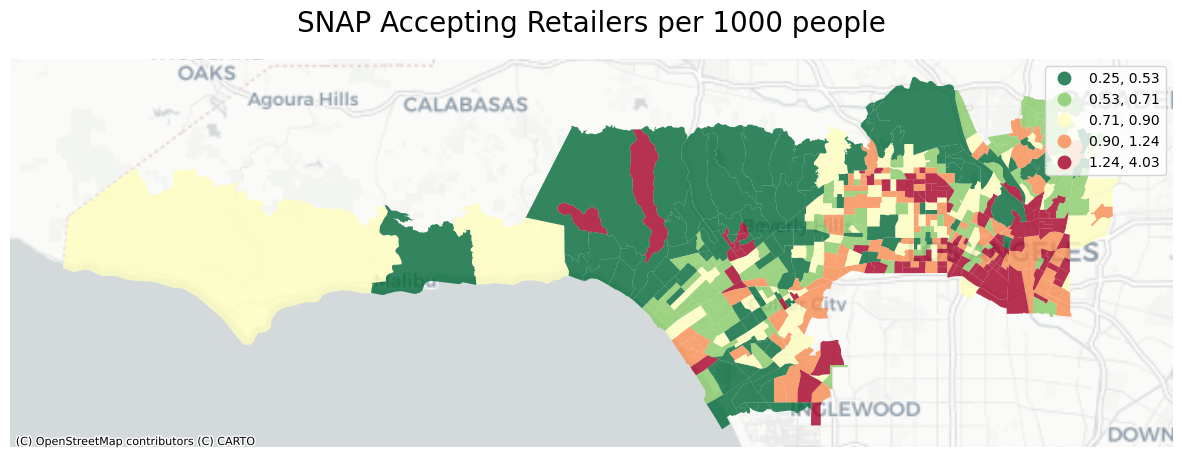

In [56]:
# use subplots that make it easier to create multiple layered maps
fig, ax = plt.subplots(figsize=(15, 15))

# spatial lag choropleth
LBW3.plot(ax=ax,
         figsize=(15,15),
         column='SNAP_per_1000_lag',
         legend=True,
         alpha=0.8,
         cmap='RdYlGn_r',
         scheme='quantiles')

ax.axis('off')
ax.set_title('SNAP Accepting Retailers per 1000 people',fontsize=20,pad=20)

ctx.add_basemap(ax,source=ctx.providers.CartoDB.Positron)

This plot displays the spatial lag of each of our census tracts. 

In [57]:
y = LBW3.SNAP_per_1000
moran = Moran(y, wq)
moran.I

0.02943294104298981

Our Moran value of 0.0294 indicates a weak but positive local autocorrelation.

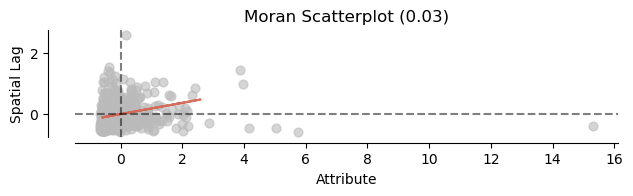

In [58]:
fig, ax = moran_scatterplot(moran, aspect_equal=True)
plt.show()

/opt/conda/lib/python3.11/site-packages/splot/_viz_esda_mpl.py:354: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sbn.kdeplot(moran.sim, shade=shade, color=color, ax=ax, **kwargs)


(<Figure size 700x700 with 1 Axes>,
 <Axes: title={'center': 'Reference Distribution'}, xlabel='Moran I: 0.03', ylabel='Density'>)

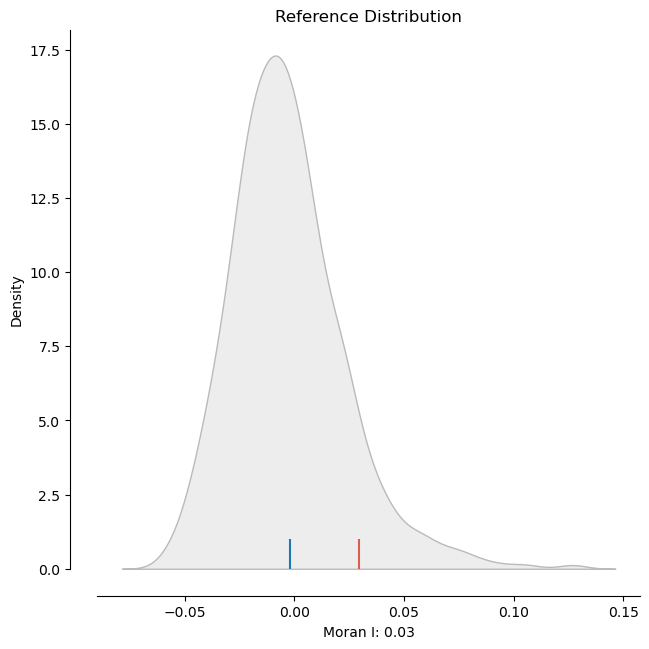

In [59]:
plot_moran_simulation(moran,aspect_equal=False)

In [60]:
moran.p_sim

0.096

Our Moran's P value is .108, which is above our alpha of .05, so we fail to reject the null hypothesis that our spatial patterns are randomly produced. Our p-value suggests that the spatial patterns in our analysis are capable of being produced by chance 11/100 times. Plotted against the distribution of simulations we see that our spatial patterns are well within the realm of random chance outcomes.

In [61]:
lisa = esda.moran.Moran_Local(y, wq)

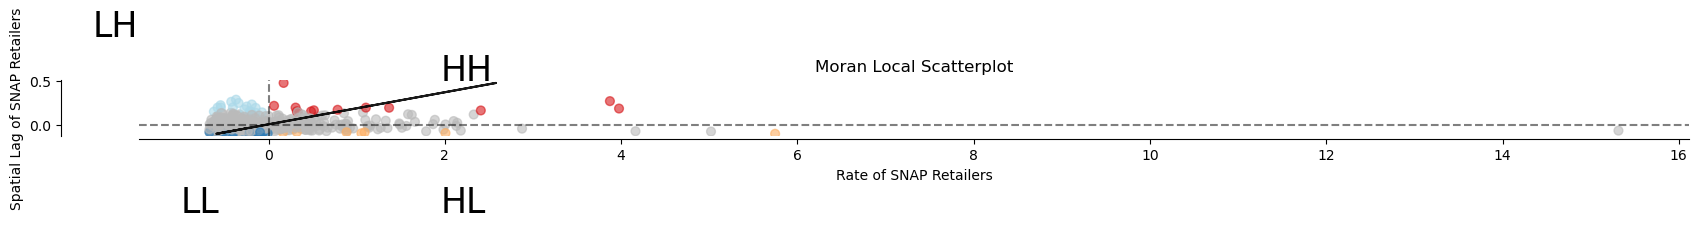

In [62]:
fig,ax = plt.subplots(figsize=(20,20))

moran_scatterplot(lisa, ax=ax, p=0.05)
ax.set_xlabel("Rate of SNAP Retailers")
ax.set_ylabel('Spatial Lag of SNAP Retailers')

# add some labels
plt.text(1.95, 0.5, "HH", fontsize=25)
plt.text(1.95, -1, "HL", fontsize=25)
plt.text(-2, 1, "LH", fontsize=25)
plt.text(-1, -1, "LL", fontsize=25)
plt.show()

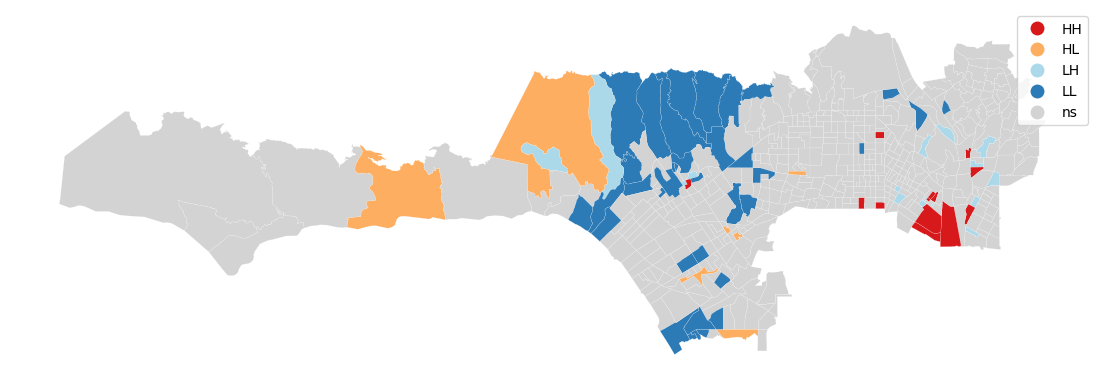

In [64]:
fig, ax = plt.subplots(figsize=(14,12))
lisa_cluster(lisa, LBW3, p=0.05, ax=ax)
plt.show()

Here is a plot and a map showing census tracts that are significantly correlated with their neighbors. HH indicates census tracts with high rates of SNAP retailers nearby others which also have high rates of SNAP retailers. Patterns indicated: that clusters of alike high SNAP-acceptance retailers per population were found in the Fashion District, Skid Row, and the census tract around the LA River just east of Skid Row. Clusters of similar low SNAP-rate retailers are found in the Hollywood Hills, Santa Monica, and Venice beach areas.  Census tracts with high rates of SNAP retailers near CTs with low rates were found in the Palisades and Malibu mountain areas. CTs with low rates of SNAP retailers near CTs with high rates were found in Brentwood directly near UCLA as well as scattered areas in SPA 4. 

SNAP retailers' availability may be very much tied to accessibility, as they want grocery stores and vendors near communities that are utilizing SNAP cards and need quick access to affordable food. These clusters we see of high SNAP-acceptance stores being around downtown also are where there are the highest rates of CalFresh cases and some of the highest rates of low birth weights. Disadvantaged communities desperately need the resources where they are. However, as you travel West, the rate of SNAP cards drops off, mostly in these higher-income communities that also tend to have lower low birth weight rates. While there may not be as high of a CalFresh distribution, that does not mean that there isn't a need. In fact, prices of food and other goods can be inflated in higher-income areas, making it a necessity for communities that exist surrounded by enclaves of higher-income communities. On an aside, is inflation across the city of Los Angeles being adequately addressed by SNAP allowances could be another angle to approach this question. 

We believe the next step is dissecting the type of stores that are available in these regions. What types of grocery stores or vendors are available to these communities? Are they able to secure affordable food that is high quality, organic, and may be specialized depending on these dietary needs? As we work to find the biggest determinant of low birth weight across our selected region, we hope to also include analyses incorporating socioeconomic factors and demographics to paint a full picture of what Low Birth Weight in Los Angeles communities looks like. 

For the work breakdown of this assignment, all group members worked collaboratively on a Zoom call to code this notebook. We took turns sharing screens, and looking up information, and dropping code snippets to drive our data exploration. After we had finished the code breakdown, we all split up the markdowns throughout the report and worked on them either on the Jupyter Notebook or on a separate Google Doc, to later be added into the notebook. This was a truly collaborative group effort :)  